In [ ]:
# Go

In [1]:
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_246911/3326843443.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# load data
var_da = 't'
level = .95
startdate = datetime(2011,1,1,0)
enddate = datetime(2011,12,31,18)
time_slice = slice(startdate,enddate)
hybrid_1_9_1_9_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/hybrid_1_9_1_9_mem_1_fixed_20110101_20120115/out.nc'
hybrid_1_9_1_9_ds = xr.open_dataset(hybrid_1_9_1_9_file)[var_da].sel(lev=level,time=time_slice)
hybrid_1_9_1_9_at_sahara = hybrid_1_9_1_9_ds.isel(lat=28,lon=5).values

time_series_data = hybrid_1_9_1_9_at_sahara


#speedy data 
speedy_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/speedy_1_9_20110101_20120101/mean_output/out.nc'
speedy_1_9_ds = xr.open_dataset(speedy_file)[var_da].sel(lev=level,time=time_slice)
speedy_1_9_at_sahara = speedy_1_9_ds.isel(lat=28,lon=5).values


var_era = 'Temperature'#'Specific_Humidity'#'Temperature' #'V-wind'
level_era = 7
print('you selected for variable =',var_era)
print('at level =',level)
timestep_6hrly = 6

# create empty list to store indiviudal datasets
era5sets = []
print('made it to the for loop...')

# LOAD DATA HERE 
print('LOADING DATA...')

# loop over the range of years and open each ds
for year in range(2011, 2011 + 1):
    nature_file = f'/skydata2/troyarcomano/ERA_5/{year}/era_5_y{year}_regridded_mpi_fixed_var.nc'
    # only load var_era selected and only load level_era selected from above
    ds_nature = xr.open_dataset(nature_file)[var_era].sel(Sigma_Level=level_era)
    # Read in every 6th timestep
    ds_nature = ds_nature.isel(Timestep=slice(None, None, timestep_6hrly))
    era5sets.append(ds_nature)

print('Now its concatinating them all together...')

ds_nature = xr.concat(era5sets, dim = 'Timestep')
ds_nature = ds_nature.sortby('Timestep')
print('Done concat and sortby Timestep...')
print(np.shape(ds_nature))

ERA5_reanal_at_sahara = ds_nature.isel(Lat=28,Lon=5)

def power_spectra(data):
    time_step = 1 / 4.0 
    power_spectra_era = np.zeros((np.shape(data)))
    print(np.shape(data)[0])
    hamming = np.hamming(np.shape(data)[0])

    fft_data = np.fft.fft(data*hamming)
    power_spectra_data = np.abs(fft_data)**2.0

    freq = np.fft.fftfreq(len(data),time_step)

    idx = np.argsort(freq)
    idx = idx[int(len(idx)/2)::]

    return power_spectra_data, freq, idx

you selected for variable = Temperature
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
(1460, 48, 96)


1460
1460
1460


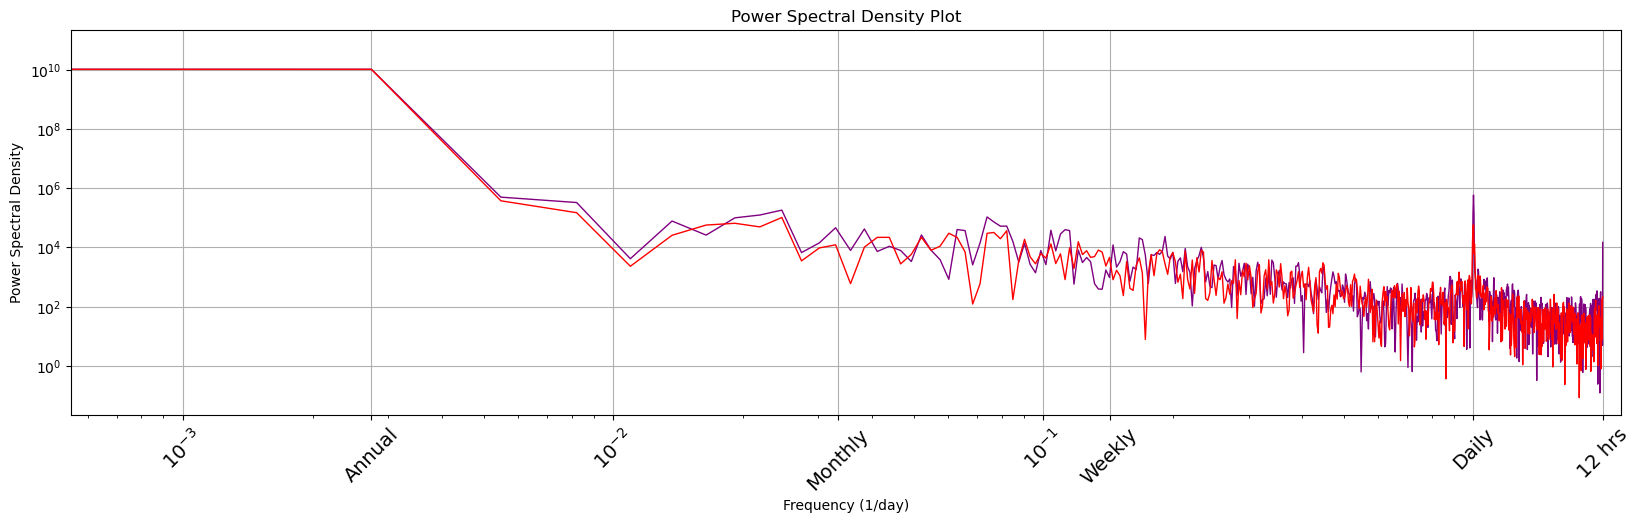

In [3]:
# Call the power_spectra function to get the data
# Call hybrid data through the function
density, f, idx = power_spectra(time_series_data)
# Call era5 data 
density_era5, f_era5, idx_era5 = power_spectra(ERA5_reanal_at_sahara)
# call speedy data
density_speedy, f_speedy, idx_speedy = power_spectra(speedy_1_9_at_sahara)


plt.figure(figsize= (20,5))

# Plot the power spectral density against frequency on a regular scale

linewidth_chosen = 1
plt.loglog(f_era5[:-1*np.shape(idx_era5)[0]], density_era5[:-1*np.shape(idx_era5)[0]], label='ERA5 Reanalysis', color = 'purple',lw=linewidth_chosen)
plt.loglog(f[:-1*np.shape(idx)[0]], density[:-1*np.shape(idx)[0]], label='LETKF-Hybrid 1.9,1.9', color='red',lw=linewidth_chosen)

plt.xlabel('Frequency (1/day)')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectral Density Plot')
plt.xlim(10**-4,1/2)
plt.grid()
xlabels_indices = [10**-3,1/365.0,10**-2,1/30.0,10**-1,1/7.0,1,2]
xlabels_cal = [r'$10^{-3}$','Annual',r'$10^{-2}$','Monthly',r'$10^{-1}$','Weekly','Daily','12 hrs']
plt.xticks(xlabels_indices, xlabels_cal, fontsize=14, rotation=45)
plt.xlim(1/(5*365.0), 2.2)
plt.show()


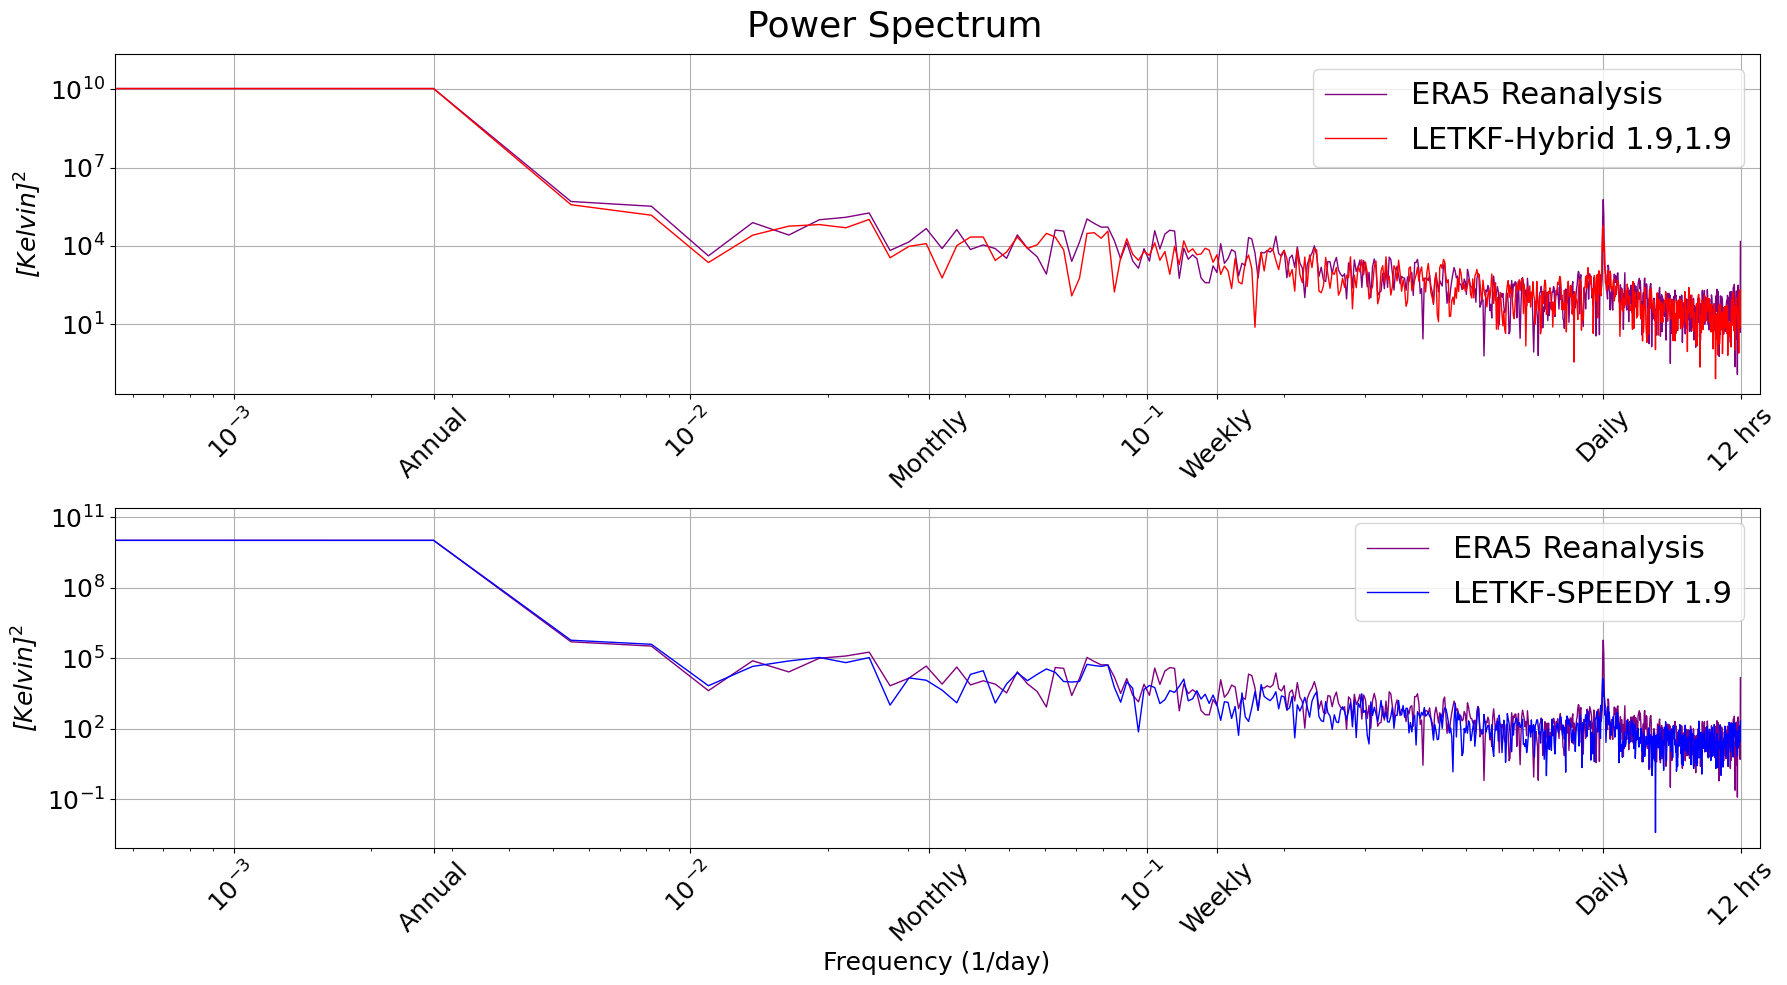

In [35]:
fig, axs = plt.subplots(2, 1, figsize=(18, 10))
fig.suptitle('Power Spectrum', fontsize=26) #)

# Plot the power spectral density against frequency on a regular scale for ERA5 Reanalysis
axs[0].loglog(f_era5[:-1*np.shape(idx_era5)[0]], density_era5[:-1*np.shape(idx_era5)[0]], label='ERA5 Reanalysis', color='purple', lw=linewidth_chosen)
axs[0].loglog(f[:-1*np.shape(idx)[0]], density[:-1*np.shape(idx)[0]], label='LETKF-Hybrid 1.9,1.9', color='red', lw=linewidth_chosen)
axs[0].set_ylabel('[Kelvin]$^2$',fontsize=18, fontstyle='italic')
axs[0].grid()
xlabels_indices = [10**-3, 1/365.0, 10**-2, 1/30.0, 10**-1, 1/7.0, 1, 2]
xlabels_cal = [r'$10^{-3}$', 'Annual', r'$10^{-2}$', 'Monthly', r'$10^{-1}$', 'Weekly', 'Daily', '12 hrs']
axs[0].set_xticks(xlabels_indices)
axs[0].set_xticklabels(xlabels_cal, fontsize=18, rotation=45)
axs[0].set_xlim(1/(5*365.0), 2.2)
axs[0].tick_params(axis='y', labelsize=18)
axs[0].legend(fontsize=22)

axs[1].loglog(f_era5[:-1*np.shape(idx_era5)[0]], density_era5[:-1*np.shape(idx_era5)[0]], label='ERA5 Reanalysis', color='purple', lw=linewidth_chosen)
axs[1].loglog(f_speedy[:-1*np.shape(idx_speedy)[0]], density_speedy[:-1*np.shape(idx_speedy)[0]], label='LETKF-SPEEDY 1.9', color='blue', lw=linewidth_chosen)
axs[1].set_xlabel('Frequency (1/day)',fontsize=18)
axs[1].set_ylabel('[Kelvin]$^2$',fontsize=18, fontstyle='italic')
axs[1].grid()
axs[1].set_xticks(xlabels_indices)
axs[1].set_xticklabels(xlabels_cal, fontsize=18, rotation=45)
axs[1].tick_params(axis='y', labelsize=18)
axs[1].set_xlim(1/(5*365.0), 2.2)
axs[1].legend(fontsize=22)

plt.tight_layout()
plt.savefig('figures_for_paper/Power_spectrum_compare_1_year_of_data_side_by_side.png',dpi=1200)
plt.show()


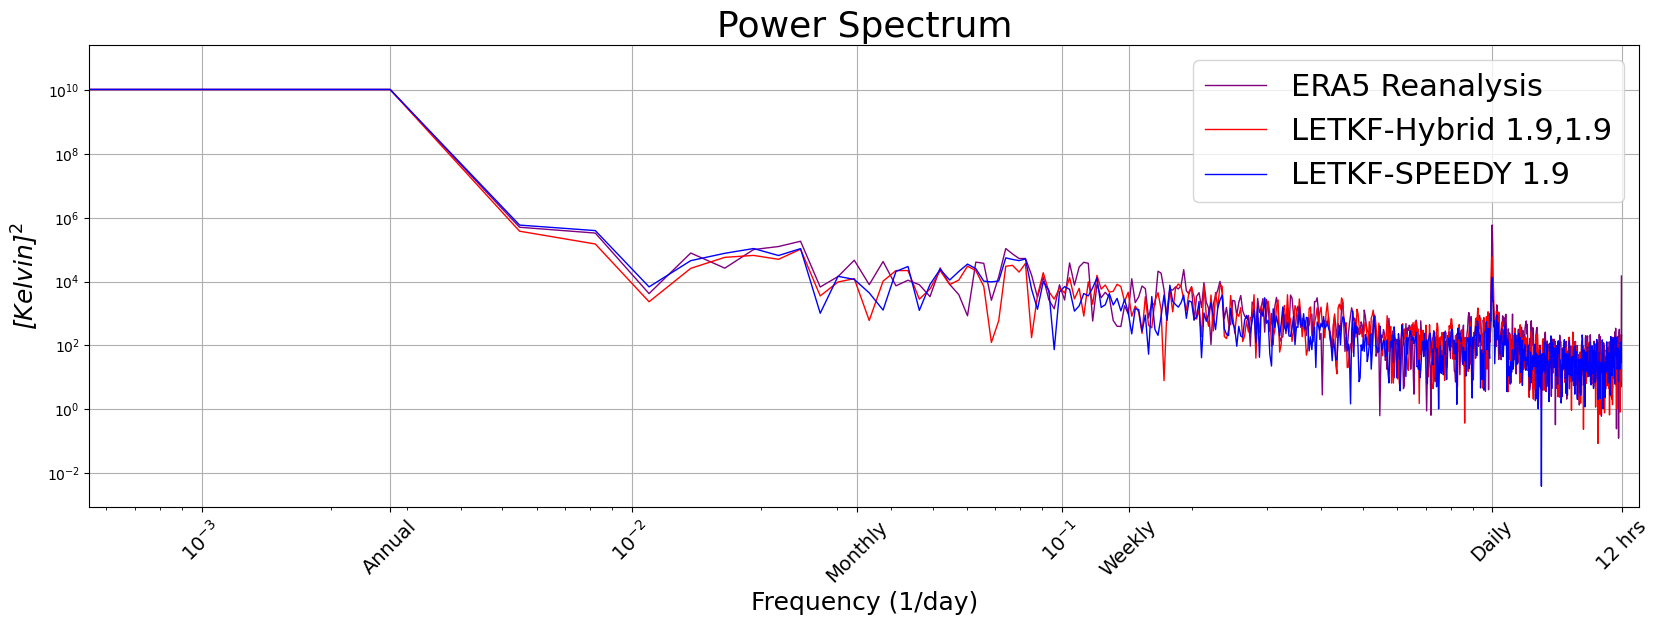

In [36]:
plt.figure(figsize= (20,6))

# Plot the power spectral density against frequency on a regular scale
plt.title('Power Spectrum', fontsize=26)
linewidth_chosen = 1
plt.loglog(f_era5[:-1*np.shape(idx_era5)[0]], density_era5[:-1*np.shape(idx_era5)[0]], label='ERA5 Reanalysis', color = 'purple',lw=linewidth_chosen)
plt.loglog(f[:-1*np.shape(idx)[0]], density[:-1*np.shape(idx)[0]], label='LETKF-Hybrid 1.9,1.9', color='red',lw=linewidth_chosen)
plt.loglog(f_speedy[:-1*np.shape(idx_speedy)[0]], density_speedy[:-1*np.shape(idx_speedy)[0]], label='LETKF-SPEEDY 1.9', color='blue', lw=linewidth_chosen)


plt.xlabel('Frequency (1/day)',fontsize=18)
plt.ylabel('[Kelvin]$^2$',fontsize=18, fontstyle='italic')
plt.xlim(10**-4,1/2)
plt.grid()
xlabels_indices = [10**-3,1/365.0,10**-2,1/30.0,10**-1,1/7.0,1,2]
xlabels_cal = [r'$10^{-3}$','Annual',r'$10^{-2}$','Monthly',r'$10^{-1}$','Weekly','Daily','12 hrs']
plt.xticks(xlabels_indices, xlabels_cal, fontsize=14, rotation=45)
plt.xlim(1/(5*365.0), 2.2)
plt.legend(fontsize=22)
plt.savefig('figures_for_paper/Power_spectrum_compare_1_year_of_data_laid_over.png',dpi=1200)
plt.show()

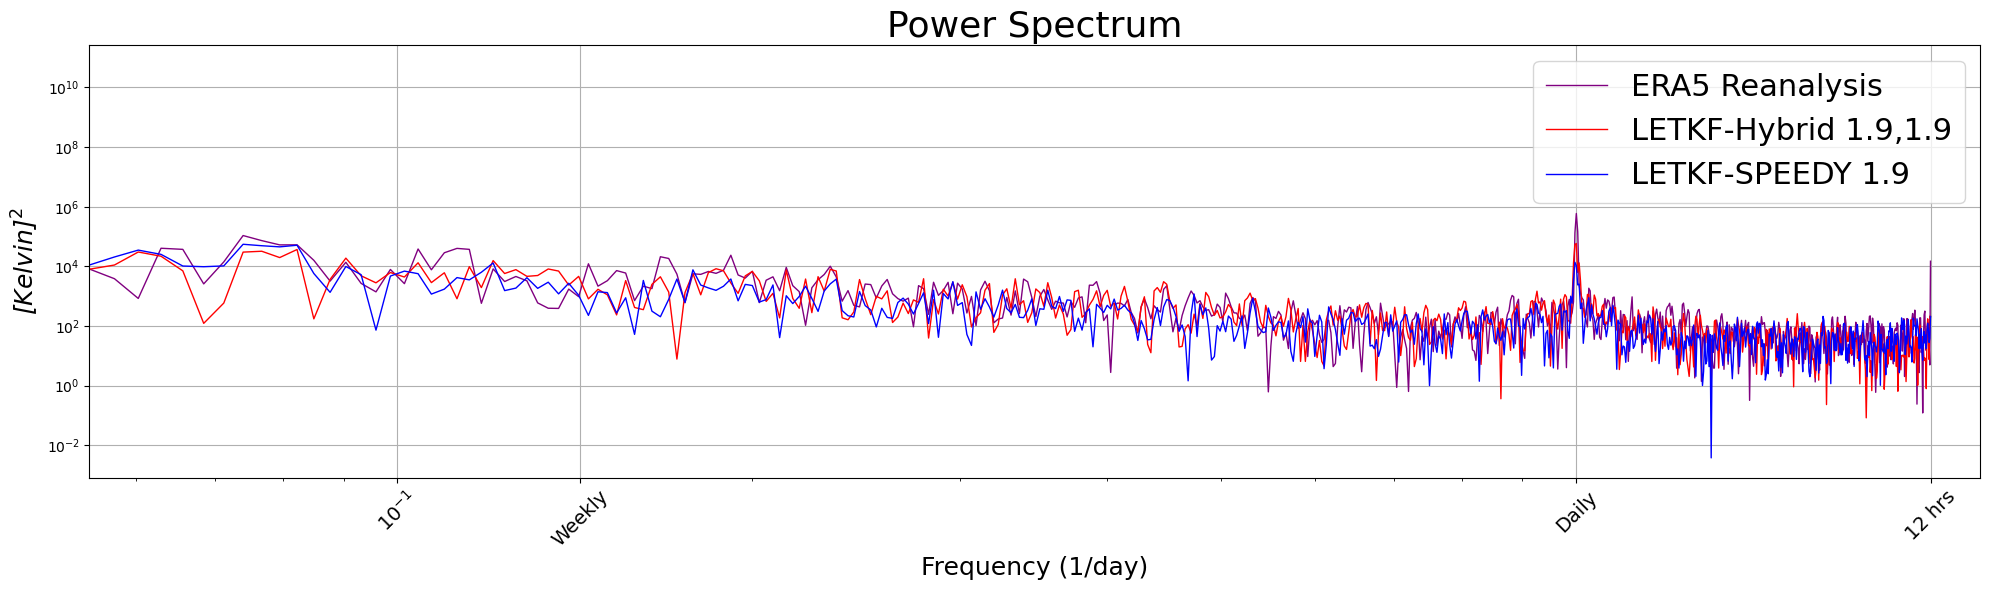

In [37]:
plt.figure(figsize= (20,6))

# Plot the power spectral density against frequency on a regular scale
plt.title('Power Spectrum', fontsize=26)
linewidth_chosen = 1
plt.loglog(f_era5[:-1*np.shape(idx_era5)[0]], density_era5[:-1*np.shape(idx_era5)[0]], label='ERA5 Reanalysis', color = 'purple',lw=linewidth_chosen)
plt.loglog(f[:-1*np.shape(idx)[0]], density[:-1*np.shape(idx)[0]], label='LETKF-Hybrid 1.9,1.9', color='red',lw=linewidth_chosen)
plt.loglog(f_speedy[:-1*np.shape(idx_speedy)[0]], density_speedy[:-1*np.shape(idx_speedy)[0]], label='LETKF-SPEEDY 1.9', color='blue', lw=linewidth_chosen)


plt.xlabel('Frequency (1/day)',fontsize=18)
plt.ylabel('[Kelvin]$^2$',fontsize=18, fontstyle='italic')
plt.xlim(10**-4,1/2)
plt.grid()
xlabels_indices = [10**-3,1/365.0,10**-2,1/30.0,10**-1,1/7.0,1,2]
xlabels_cal = [r'$10^{-3}$','Annual',r'$10^{-2}$','Monthly',r'$10^{-1}$','Weekly','Daily','12 hrs']
plt.xticks(xlabels_indices, xlabels_cal, fontsize=14, rotation=45)
plt.xlim(1/(5*365.0/100), 2.2)
plt.legend(fontsize=22)
plt.tight_layout()
plt.savefig('figures_for_paper/Power_spectrum_compare_1_year_of_data_only1yearshowing.png',dpi=1200)

plt.show()

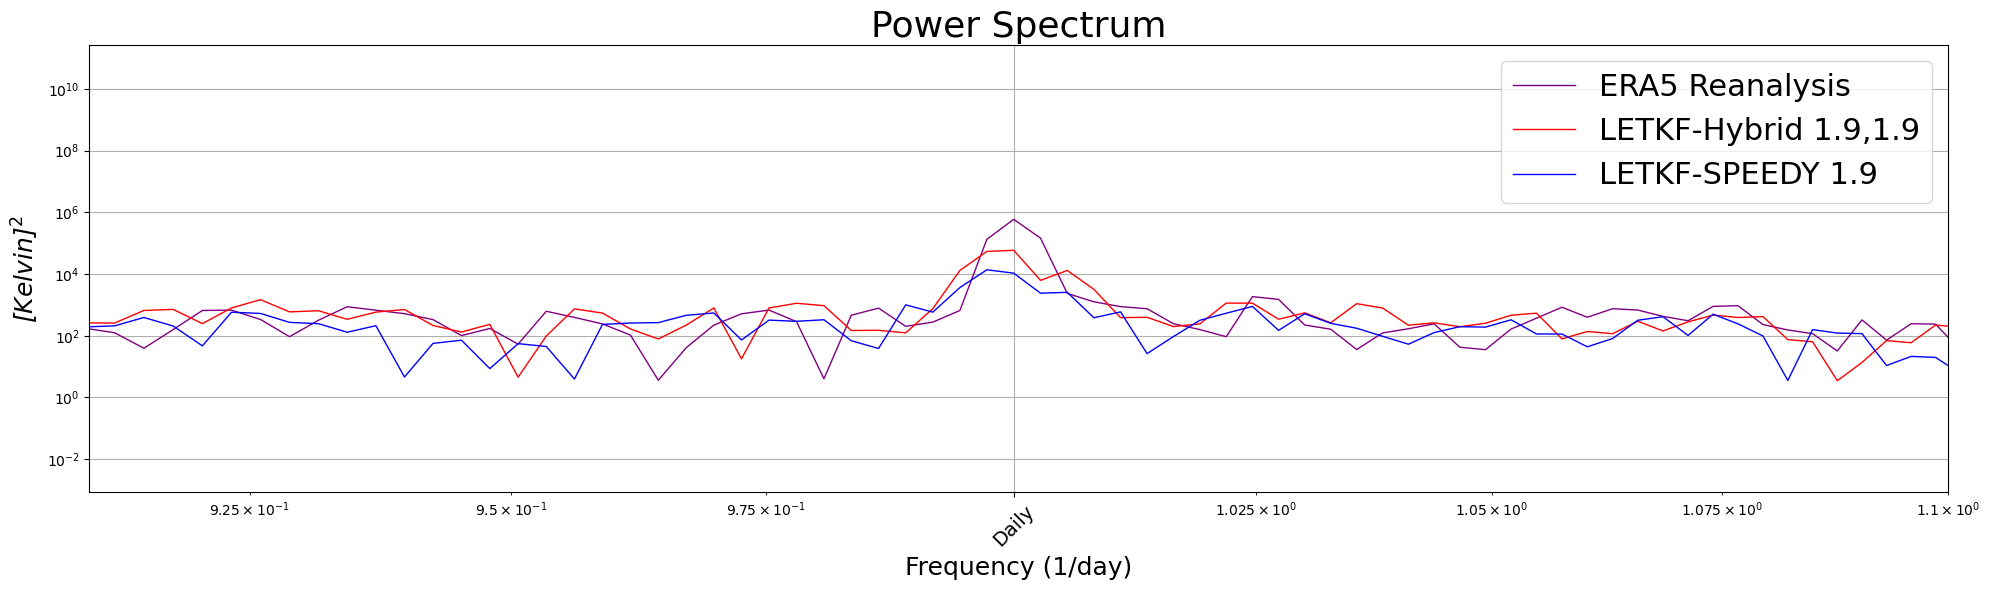

In [38]:
plt.figure(figsize= (20,6))

# Plot the power spectral density against frequency on a regular scale
plt.title('Power Spectrum', fontsize=26)
linewidth_chosen = 1
plt.loglog(f_era5[:-1*np.shape(idx_era5)[0]], density_era5[:-1*np.shape(idx_era5)[0]], label='ERA5 Reanalysis', color = 'purple',lw=linewidth_chosen)
plt.loglog(f[:-1*np.shape(idx)[0]], density[:-1*np.shape(idx)[0]], label='LETKF-Hybrid 1.9,1.9', color='red',lw=linewidth_chosen)
plt.loglog(f_speedy[:-1*np.shape(idx_speedy)[0]], density_speedy[:-1*np.shape(idx_speedy)[0]], label='LETKF-SPEEDY 1.9', color='blue', lw=linewidth_chosen)


plt.xlabel('Frequency (1/day)',fontsize=18)
plt.ylabel('[Kelvin]$^2$',fontsize=18, fontstyle='italic')
plt.xlim(10**-4,1/2)
plt.grid()
xlabels_indices = [10**-3,1/365.0,10**-2,1/30.0,10**-1,1/7.0,1,2]
xlabels_cal = [r'$10^{-3}$','Annual',r'$10^{-2}$','Monthly',r'$10^{-1}$','Weekly','Daily','12 hrs']
plt.xticks(xlabels_indices, xlabels_cal, fontsize=14, rotation=45)
plt.xlim(.91,1.1)#1/(5*365.0/1400), 1.2)#2.1)
plt.legend(fontsize=22)
plt.tight_layout()
plt.savefig('figures_for_paper/Power_spectrum_compare_1_year_of_data_closeup.png',dpi=1200)

plt.show()